/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Feature ranking:
400.0
0.862547619048


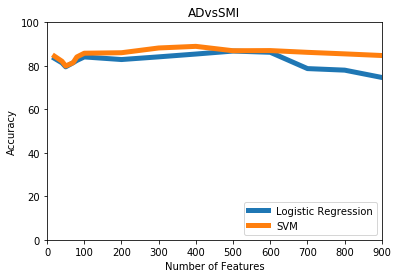

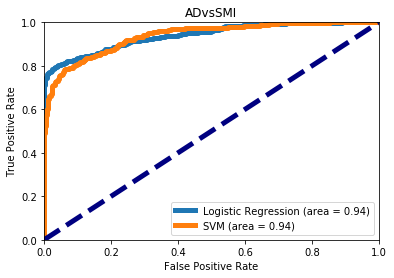

In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
from pprint import pprint
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
import re
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
#s = "../braindata/data_1_mor_select_100.csv"
import os          
from sklearn import linear_model, svm
from sklearn.ensemble import ExtraTreesClassifier

os.getcwd()
os.chdir('../braindata')
dd =pd.read_csv("data_1_mor.csv",header=0)
import csv

with open('data_1_mor.csv', 'r') as f:
    d_reader = csv.DictReader(f)

    #get fieldnames from DictReader object and store in list
    headers = d_reader.fieldnames
data=np.array(dd)
#print(data.shape)
idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))
X=data[:,idx_IN_columns]
#features=data[:,11:data.shape[1]]
#features = features.transpose()
X = stats.zscore(X)
#print(features.shape)
y=data[:,5]
#5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv

ind_num=np.isnan(y)
# print(ind_num.shape)


y_no_nan = y[~ind_num]

X_no_nan = X[~ind_num,:]

       # print(y.shape)

y=y_no_nan
X=X_no_nan
feature_num_all=[]
lr_all_feature=[]
svm_all_feature=[]
lr_fls_feature=[]
svm_fls_feature=[]
base_labels= []

#X=X.reshape(X.size,1)
#X=X.astype(np.float64,copy=False)
np.isnan(X).any()
#feature_num=features.shape[1]
X[np.isnan(X)] = np.median(X[~np.isnan(X)])
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
clf = clf.fit(X, y)
importances = clf.feature_importances_
importances
indices = np.argsort(importances)[::-1]
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#n_features = [10,30,50,70,80,100,1000,2000,13000,18000,10000,20000,3000,30000,4000,500,5000,6000,7000,8000,9000,15000,25000]
n_features = [20,40,50,70,80,100,200,300,400,500,600,700,800,900]

n_features.sort()

for i in n_features:
#     #print(i)
    
#     #lsvc = LinearSVC(C=J[i],penalty="l1", dual=True).fit(X, y)
#     #model = SelectFromModel(lsvc, prefit=True)
#     #features = model.transform(X)
#     clf = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)
#     clf = clf.fit(X, y)
#     importances = forest.feature_importances_
       
    index=indices[0:i]
    features=X[:,index]
#     clf.feature_importances_ 

#     model = SelectFromModel(clf, threshold=0.6,prefit=True)
#     features = model.transform(X)
#     features.shape               
#     #features=features.reshape(features.size,1)
#     #features=features.astype(np.float64,copy=false)
#     np.isnan(features).any()
    feature_num=features.shape[1]
    #print(feature_num)
    
  
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []
    #base_labels = []
    for runs in range(1):
        lr_accuracies = []
        lr_scores = []
        svm_accuracies = []
        svm_scores = []
        strat_labels = []
        
        logistic = linear_model.LogisticRegression(C=1e5)
        rbf = svm.SVC(C=10,kernel='linear',gamma=0.01)

        skf=RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
        for train_index, test_index in skf.split(features, y):
                    train_data, test_data = features[train_index], features[test_index]
                    train_labels, test_labels = y[train_index], y[test_index]

                    strat_labels = np.append(strat_labels, test_labels)

                    log = logistic.fit(train_data, train_labels)
                    log_prob = log.decision_function(test_data)
                    log_acc = log.score(test_data, test_labels)

                    #f1 calculation
                    y_pred = logistic.predict(test_data)
                    log_f1 = f1_score(test_labels, y_pred)

                    lr_accuracies = np.append(lr_accuracies, log_acc)
                    lr_scores = np.append(lr_scores, log_prob)
                    lr_f1s = np.append(lr_f1s, log_f1)
                    #print('Logistic Regression Accuracy: %f' % log_acc)

                    rbf = rbf.fit(train_data, train_labels)
                    svm_acc = rbf.score(test_data, test_labels)
                    svm_prob = rbf.decision_function(test_data)

                    #f1 calculation
                    y_pred = rbf.predict(test_data)
                    svm_f1 = f1_score(test_labels, y_pred)
                    #print('SVM Accuracy: %f' % svm_acc)
                    svm_accuracies = np.append(svm_accuracies, svm_acc)
                    svm_scores = np.append(svm_scores, svm_prob)
                    svm_f1s = np.append(svm_f1s, svm_f1)

                    lr_all_scores = np.append(lr_all_scores, lr_scores)
                    lr_fold_avg = np.mean(lr_accuracies)
                    lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
                    svm_all_scores = np.append(svm_all_scores, svm_scores)
                    svm_fold_avg = np.mean(svm_accuracies)
                    svm_all_accs = np.append(svm_all_accs, svm_fold_avg)
                    #print('Logistic Regression Accuracy: %f' % log_acc_avg)
                            #print('SVM Regression Accuracy: %f' % svm_acc_avg)
        feature_num_all=np.append(feature_num_all,feature_num)
# print(np.mean(lr_all_accs))
# print(np.mean(svm_all_accs))      
        lr_all_feature=np.append(lr_all_feature,np.mean(lr_all_accs))
        svm_all_feature=np.append(svm_all_feature,np.mean(svm_all_accs))
        lr_fls_feature=np.append(lr_fls_feature,np.mean(lr_f1s))
        svm_fls_feature=np.append(svm_fls_feature,np.mean(svm_f1s))
        #base_labels_all = np.append(base_labels_all,strat)
        base_labels = np.append(base_labels, np.mean(strat_labels))


import matplotlib.pyplot as plt

plt.figure()
plt.plot( (feature_num_all), lr_all_feature*100, lw=5, label='Logistic Regression')
plt.plot( (feature_num_all), svm_all_feature*100, lw=5, label='SVM')
plt.xlim([0, 900])
plt.ylim([0, 100])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('ADvsSMI')
plt.legend(loc="lower right")
plt.savefig('/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMI_ALL.pdf')
#plt.show()

svm_f1s=svm_f1s[np.nonzero(svm_f1s)]
#print(svm_f1s)

# print("LR accuracy Avg: {}".format(np.mean(lr_all_feature)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
# print("LR accuracy Standard Deviation: {}".format(np.std(lr_all_feature)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))

# print("LR f1s Avg : {}".format(np.mean( lr_fls_feature)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
# print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))

# print("SVM Avg: {}".format(np.mean(svm_all_feature)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
# print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))

# print("SVM f1s Avg : {}".format(np.mean( svm_fls_feature )),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
# print("SVM f1s Standard Deviation: {}".format(np.std(svm_fls_feature)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
lrindex=np.argmax(lr_all_feature)
# print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
svmindex=np.argmax(svm_all_feature)
# print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))


clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
clf = clf.fit(X, y)
importances = clf.feature_importances_
#importances
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(100):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],headers[indices[f]],importances[indices[f]]),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMI_rank.txt", "a"))

    
#################################################################################################################    
from sklearn import metrics

max_features = feature_num_all[svmindex]
print(max_features)
lr_all_accs = []
lr_all_scores = []
lr_f1s = []
svm_all_accs = []
svm_all_scores = []
svm_f1s = []
base_labels = []
lr_sensitivity= []
svm_sensitivity=[]
lr_specificity=[]
svm_specificity=[]

index=indices[0:int(max_features)]
features=X[:,index]
feature_num=features.shape[1]
for runs in range(1):
    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []

    logistic = linear_model.LogisticRegression(C=1e5)
    rbf = svm.SVC(C=10,kernel='linear',gamma=0.01)
    
    skf=RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    for train_index, test_index in skf.split(features, y):
                train_data, test_data = features[train_index], features[test_index]
                train_labels, test_labels = y[train_index], y[test_index]
                #print(train_data.shape)
                strat_labels = np.append(strat_labels, test_labels)

                log = logistic.fit(train_data, train_labels)
                log_prob = log.decision_function(test_data)
                log_acc = log.score(test_data, test_labels)

                #f1 calculation
                y_pred = logistic.predict(test_data)
                log_f1 = f1_score(test_labels, y_pred)
                log_confuse= metrics.confusion_matrix(test_labels, y_pred)
                TP = log_confuse[1, 1]
                TN = log_confuse[0, 0]
                FP = log_confuse[0, 1]
                FN = log_confuse[1, 0]
                log_sen=metrics.recall_score(test_labels, y_pred)
    #             print(TN)
    #             print(FP)
                log_spec=TN / (TN + FP)
    #             print(log_confuse)
    #             print(log_sen)
    #             print(log_spec)

                lr_accuracies = np.append(lr_accuracies, log_acc)
                lr_sensitivity=np.append(lr_sensitivity, log_sen)
                lr_specificity=np.append(lr_specificity, log_spec)

                lr_scores = np.append(lr_scores, log_prob)
                lr_f1s = np.append(lr_f1s, log_f1)

                #print('Logistic Regression Accuracy: %f' % log_acc)

                rbf = rbf.fit(train_data, train_labels)
                svm_acc = rbf.score(test_data, test_labels)
                svm_prob = rbf.decision_function(test_data)

                #f1 calculation
                y_pred = rbf.predict(test_data)
                svm_f1 = f1_score(test_labels, y_pred)
                svm_confuse= metrics.confusion_matrix(test_labels, y_pred)
                TP = log_confuse[1, 1]
                TN = log_confuse[0, 0]
                FP = log_confuse[0, 1]
                FN = log_confuse[1, 0]
                svm_sen=metrics.recall_score(test_labels, y_pred)
                svm_spec=TN / (TN + FP)



                svm_accuracies = np.append(svm_accuracies, log_acc)
                svm_sensitivity=np.append(svm_sensitivity, log_sen)
                svm_specificity=np.append(svm_specificity, log_spec)

                #print('SVM Accuracy: %f' % svm_acc)
                svm_accuracies = np.append(svm_accuracies, svm_acc)
                svm_scores = np.append(svm_scores, svm_prob)
                svm_f1s = np.append(svm_f1s, svm_f1)

    base_labels = np.append(base_labels, strat_labels)
    lr_all_scores = np.append(lr_all_scores, lr_scores)
    lr_fold_avg = np.mean(lr_accuracies)
    lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
    svm_all_scores = np.append(svm_all_scores, svm_scores)
    svm_fold_avg = np.mean(svm_accuracies)
    svm_all_accs = np.append(svm_all_accs, svm_fold_avg)

# feature_num_all=np.append(feature_num_all,feature_num)
# # print(np.mean(lr_all_accs))
print(np.mean(svm_all_accs))      
# lr_all_feature=np.append(lr_all_feature,np.mean(lr_all_accs))
# print(lr_all_feature)
# svm_all_feature=np.append(svm_all_feature,np.mean(svm_all_accs))
# print(np.mean(svm_accuracies))
# lr_fls_feature=np.append(lr_fls_feature,np.mean(lr_f1s))
# svm_fls_feature=np.append(svm_fls_feature,np.mean(svm_f1s))
#base_labels_all = np.append(base_labels_all,strat)
#base_labels = np.append(base_labels, np.mean(strat_labels))

print("LR accuracy Avg: {}".format(np.mean(lr_accuracies)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR accuracy Standard Deviation: {}".format(np.std(lr_accuracies)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR sensitivity Avg: {}".format(np.mean(lr_sensitivity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR sensitivity Standard Deviation: {}".format(np.std(lr_sensitivity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR specificity Avg: {}".format(np.mean(lr_specificity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR specificity Standard Deviation: {}".format(np.std(lr_specificity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR f1s Avg : {}".format(np.mean(lr_f1s)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))

print("SVM Avg: {}".format(np.mean(svm_accuracies)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM Standard Deviation: {}".format(np.std(svm_accuracies)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM sensitivity Avg: {}".format(np.mean(svm_sensitivity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM sensitivity Standard Deviation: {}".format(np.std(svm_sensitivity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM specificity Avg: {}".format(np.mean(svm_specificity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM specificity Standard Deviation: {}".format(np.std(svm_specificity)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM f1s Avg : {}".format(np.mean(svm_f1s)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
print("SVM f1s Standard Deviation: {}".format(np.std(svm_f1s)),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
#lrindex=np.argmax(lr_all_feature)
print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))
#svmindex=np.argmax(svm_all_feature)
print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open("/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ADvsSMIaccuracy.txt", "a"))


###############################################################################################################

from sklearn.metrics import roc_curve, auc,f1_score
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
#f1['lr']=f1_score(fpr['lr'], tpr['lr'])
fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
#f1['svm']=f1_score(fpr['svm'], tpr['svm'])
#fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
#roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

plt.figure()
plt.plot(fpr['lr'], tpr['lr'], lw=5, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'] )
#plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (f1 = %0.2f)' % f1['lr'] )
plt.plot(fpr['svm'], tpr['svm'], lw=5, label='SVM (area = %0.2f)' % roc_auc['svm'] )
#plt.plot(fpr['svm'], tpr['svm'f], lw=3, label='SVM (f1 = %0.2f)' % f1['svm'] )
#plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADvsSMI')
plt.legend(loc="lower right") 
#plt.savefig('10x_Combined_ROC.eps')
#plt.savefig('ROC_MCIVsNormal_connectome.eps')
plt.savefig('/Users/yunwang/Dropbox (NYSPI)/00 AD ML/0papers/0Neuroimage-Clinical/Figures/ROC_ADvsSMI_connectome.pdf')

plt.show()